In [0]:
# cd '/content/drive/My Drive/Colab Notebooks/Amazon/Data'

In [3]:
!curl -L https://www.dropbox.com/s/qsdq7sx946t39pa/amazon.tar?dl=1 -o amazon.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  637M  100  637M    0     0  35.7M      0  0:00:17  0:00:17 --:--:-- 42.7M


In [4]:
!tar xvf amazon.tar

Streaming output truncated to the last 5000 lines.
amazon/train-jpg/train_19718.jpg
amazon/train-jpg/train_38480.jpg
amazon/train-jpg/train_16787.jpg
amazon/train-jpg/train_621.jpg
amazon/train-jpg/train_28212.jpg
amazon/train-jpg/train_29928.jpg
amazon/train-jpg/train_30979.jpg
amazon/train-jpg/train_12790.jpg
amazon/train-jpg/train_37996.jpg
amazon/train-jpg/train_4564.jpg
amazon/train-jpg/train_423.jpg
amazon/train-jpg/train_15263.jpg
amazon/train-jpg/train_28557.jpg
amazon/train-jpg/train_17206.jpg
amazon/train-jpg/train_28792.jpg
amazon/train-jpg/train_12157.jpg
amazon/train-jpg/train_3899.jpg
amazon/train-jpg/train_34358.jpg
amazon/train-jpg/train_9458.jpg
amazon/train-jpg/train_15756.jpg
amazon/train-jpg/train_6353.jpg
amazon/train-jpg/train_2794.jpg
amazon/train-jpg/train_34451.jpg
amazon/train-jpg/train_11776.jpg
amazon/train-jpg/train_26449.jpg
amazon/train-jpg/train_15881.jpg
amazon/train-jpg/train_21669.jpg
amazon/train-jpg/train_31322.jpg
amazon/train-jpg/train_3449.jpg
am

In [0]:
import pandas as pd
import numpy as np
np.random.seed(0)

import cv2

from tqdm.notebook import tqdm
import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.applications import ResNet50, VGG16

from sklearn.metrics import fbeta_score
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

import gc

In [9]:
import tensorflow.keras.applications
dir(tensorflow.keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [0]:
base_models = ['DenseNet121', 'DenseNet169', 'DenseNet201', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception']

In [0]:
for model in base_models:
  exec('from tensorflow.keras.applications import {}'.format(model))

In [12]:
ls

amazon/  sample_data/


In [13]:
df_train = pd.read_csv('amazon/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
def read_data(df_train, labels, resize=(32, 32)):
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in tqdm(df_train.values, miniters=1000):
        if False == os.path.exists('amazon/train-jpg/{}.jpg'.format(f)): continue

        img = cv2.imread('amazon/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(len(label_map))
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        X_train.append(cv2.resize(img, resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.
    
    split = 35000
    
    # X_train, X_test, y_train, y_test
    return X_train[:split], X_train[split:], y_train[:split], y_train[split:]

def score_model(model):
  y_pred = model.predict(X_test, batch_size=128)
  score = fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average='samples')

  print("\nTest score (f1): ", score)
  print("Error: %.2f%%" % (100-score*100))
  print('\n\n')

def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

    return result

In [17]:
all_labels = df_train['tags'].map(lambda x: x.split(' ')).values
labels = list(set([y for x in all_labels for y in x]))

print( len(labels), labels )

17 ['artisinal_mine', 'cultivation', 'clear', 'water', 'road', 'selective_logging', 'partly_cloudy', 'bare_ground', 'cloudy', 'slash_burn', 'blooming', 'blow_down', 'primary', 'haze', 'conventional_mine', 'agriculture', 'habitation']


In [11]:
X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(64, 64))

In [12]:
X_train.shape

(35000, 64, 64, 3)

In [13]:
model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Flatten(), 

        Dense(256, activation='relu'),
        Dense(17, activation='sigmoid') 
        ])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       7

In [14]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))

print()
score_model(model)

Epoch 1/5
274/274 [==============================] - 13s 48ms/step - loss: 0.2462 - accuracy: 0.0085 - val_loss: 0.2257 - val_accuracy: 0.0000e+00
Epoch 2/5
274/274 [==============================] - 12s 44ms/step - loss: 0.2014 - accuracy: 0.0260 - val_loss: 0.1784 - val_accuracy: 0.0613
Epoch 3/5
274/274 [==============================] - 12s 45ms/step - loss: 0.1705 - accuracy: 0.0639 - val_loss: 0.1691 - val_accuracy: 0.0663
Epoch 4/5
274/274 [==============================] - 12s 44ms/step - loss: 0.1503 - accuracy: 0.1353 - val_loss: 0.1436 - val_accuracy: 0.2254
Epoch 5/5
274/274 [==============================] - 12s 45ms/step - loss: 0.1425 - accuracy: 0.1493 - val_loss: 0.1400 - val_accuracy: 0.0663

Test score (f1):  0.868976091906352
Error: 13.10%


##Transfer layrning

In [18]:
# del X_train, X_test, y_train, y_test
# gc.collect()

X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(48, 48))

In [0]:
train_history = []
test_history = []


def test_base_model(base_model, test_plan):
  global train_history
  global test_history
  train_history = []
  test_history = []

  base_model.summary()
  model = add_mlp_to_base_model(base_model)
  model.summary()
  metrics = [fbeta_score_K]
  
  for test_stage, (trainable_layers, epochs) in enumerate(test_plan):

    if test_stage == 1:
      optimizer = Adam(0.003, decay=0.0005)
    else:
      optimizer = Adam(0.0003, decay=0.000005)
    
    set_trainable_layers(model, trainable_layers)
    print_trainable_count(model)
    training_cycle(model, optimizer, metrics, epochs)

  draw_learning_curve([train_history, test_history], metrics[0])

def training_cycle(model, optimizer, metrics, epochs):
  global train_history
  global test_history

  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
  history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
  
  train_history += history.history[metrics[0].__name__]
  test_history += history.history['val_' + metrics[0].__name__]
  score_model(model)

def set_trainable_layers(model, trainable_layers):
  for layer in model.layers[0].layers:
    layer.trainable = False

  if trainable_layers == 0: return 

  for layer in model.layers[0].layers[-trainable_layers:]:
    layer.trainable = True

def print_trainable_count(model):
  trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
  non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

  print('Total params: {:,}'.format(trainable_count + non_trainable_count))
  print('Trainable params: {:,}'.format(trainable_count))
  print('Non-trainable params: {:,}'.format(non_trainable_count))

def add_mlp_to_base_model(base_model):
  for layer in base_model.layers:
    layer.trainable = False
    
  model = Sequential([
      base_model,
      
      Flatten(), 
          
      Dense(128, activation='relu'),
      Dropout(0.2),
      Dense(17, activation='sigmoid')
      
  ])

  return model

def draw_learning_curve(history, key='accuracy'):
  plt.figure(figsize=(12,6))

  if type(history) == tensorflow.python.keras.callbacks.History:
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    ylim = (0, 1.01)
  else:
    history = list(history)
    train_hiostory = history[0]
    test_hiostory = history[1]
    ylim = ( min(train_hiostory + test_hiostory) - 0.01,  max(train_hiostory + test_hiostory) + 0.01)
    plt.plot(train_hiostory)
    plt.plot(test_hiostory)


  plt.title('Learning Curve')
  plt.ylabel(key.__name__)
  plt.xlabel('Epoch')
  plt.ylim(ylim)
  plt.legend(['train', 'test'], loc='best')
  plt.show()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

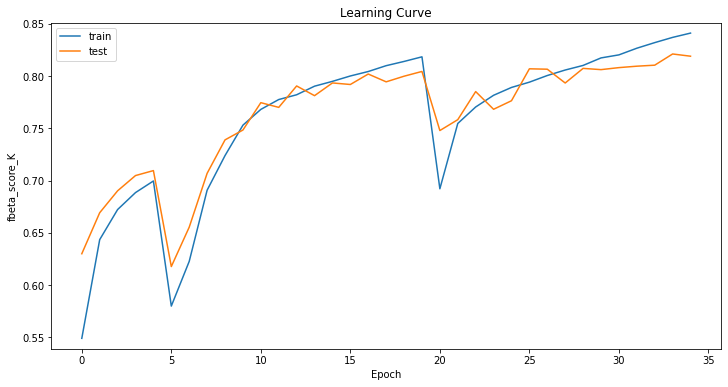

In [88]:
trainable_layers = [0, 4, 8]
epochs           = [5, 15, 15]
test_plan = zip(trainable_layers, epochs)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
test_base_model(base_model, test_plan)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

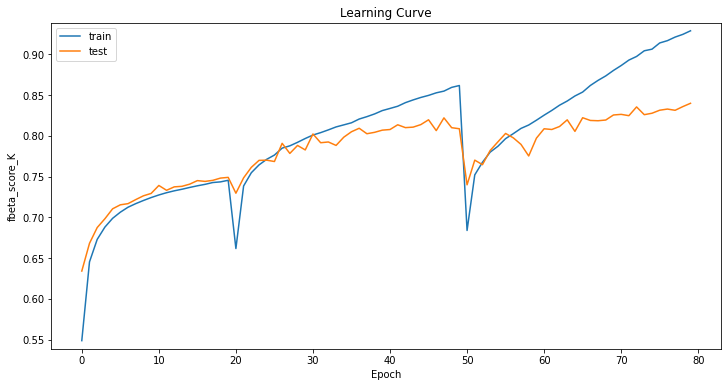

In [89]:
trainable_layers = [0, 4, 8]
epochs           = [20, 30, 30]
test_plan = zip(trainable_layers, epochs)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
test_base_model(base_model, test_plan)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

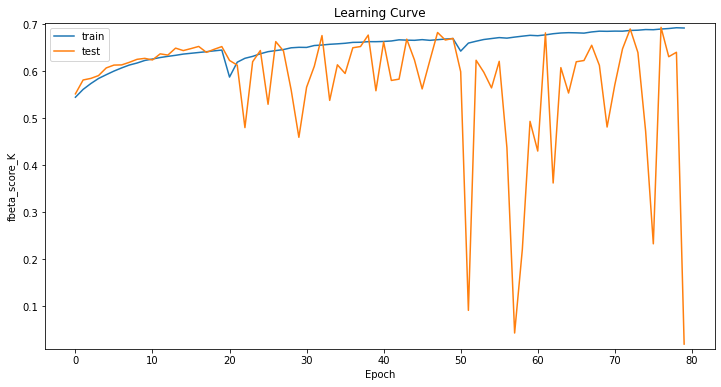

In [92]:
trainable_layers = [0, 4, 10]
epochs           = [20, 30, 30]
test_plan = zip(trainable_layers, epochs)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
test_base_model(base_model, test_plan)

##All in

In [0]:
trainable_layers = [0, 5, 10]
epochs           = [5, 15, 15]
test_plan = zip(trainable_layers, epochs)

In [36]:
list(test_plan)

[(0, 5), (5, 10), (10, 15)]

In [63]:
for i, (b, e) in enumerate(test_plan):
  print(i, b, e)

0 0 5
1 5 15
2 10 15


In [0]:
a = [1,2,3,4]

In [84]:
a[-2:]

[3, 4]